In [1]:
import time
import os
import sys
sys.path.append('..')

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
import utils.plot

import torchvision

/home/xzhang/anaconda3/envs/c2p/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
resolution='5'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'
with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res'+resolution
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
with open(os.path.join(saveDir,'metadataClf','exp0_pathDiagClf_modSilFilter_2','log','clusterUsed'), 'rb') as output:
    finalPartition_keep=pickle.load(output)

In [8]:
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1
print(finalPartition_keep_input.shape)
print(np.unique(finalPartition_keep_input))
finalPartition_keep_input_unique,labels,finalPartition_keep_input_counts=np.unique(finalPartition_keep_input,return_counts=True,return_inverse=True)


In [4]:
savedir_processed_new='/data/xzhang/neuro_new/newdata/tauAbeta_tiff/processed'

with open(os.path.join(savedir_processed_new,'allImgs_minmax_segNuc'), 'rb') as output:
    allImg_tauAb=pickle.load(output)
print(allImg_tauAb.shape)

(24966, 5, 128, 128)


In [10]:
allImg_tauAb_input=allImg_tauAb[:,:3]
imgSize=allImg_tauAb_input.shape[2]
saveFreq=50

batchsize=256

name='img2clusterID_dapi_lmnb_map2'
modelname_train='resnet18'
savepath_curr=os.path.join(saveDir,'clusterClf',name)
logsavepath=os.path.join(savepath_curr,'log')
modelsavepath=os.path.join(savepath_curr,'model')
plotsavepath=os.path.join(savepath_curr,'plots')




In [12]:
nSamples=6
valIdx=np.arange(allImg_tauAb_input.shape[0])
res_pred=np.zeros((nSamples,valIdx.size))

for sample_s in range(nSamples):
    print(sample_s)
    seed=sample_s
    np.random.seed(sample_s)
    pctVal=0.1


    logsavepath_train_curr=os.path.join(logsavepath,str(sample_s))
    modelsavepath_train_curr=os.path.join(modelsavepath,str(sample_s))
    plotsavepath_train_curr=os.path.join(plotsavepath,str(sample_s))
    
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=finalPartition_keep_input_unique.size)
        model.conv1=torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=finalPartition_keep_input_unique.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,finalPartition_keep_input_unique.size)
    model.cuda()

    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
        val_loss=pickle.load(output)
    minlossepoch=np.argmin(val_loss)
    minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
        if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
            minlossepoch_saved=minlossepoch_saved+saveFreq
        else:
            minlossepoch_saved=minlossepoch_saved-saveFreq
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

    #validation samples
    with torch.no_grad():
        model.eval()
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        pred_curr=np.array([])
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg_tauAb_input[valIdx_i]).cuda().float()

            pred = model(valInput)

            pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))


    res_pred[sample_s]=pred_curr.astype(int)
    
    
with open(os.path.join(plotsavepath,'pred_tauAb'), 'wb') as output:
    pickle.dump(res_pred, output, pickle.HIGHEST_PROTOCOL)



0
1
2
3
4
5


In [22]:
res_pred_mode=scipy.stats.mode(res_pred,axis=0)[0]
res_pred_mode=finalPartition_keep_input_unique[res_pred_mode.astype(int)]

In [39]:
row_order_all=np.array([ 0.,  3., 13., 14., 18., 36., 39., 62., 66., 74., 82., 94.,  1.,
        4., 11., 17., 21., 28., 32., 53., 97., 99.,  2.,  7., 19., 20.,
       34., 84., 85.])
_,predIdx,_=np.intersect1d(res_pred_mode_unique,row_order_all,return_indices=True)
print(np.sum(res_pred_mode_counts[predIdx]<100))
res_pred_mode_unique[predIdx][res_pred_mode_counts[predIdx]<100]

15


array([ 1,  2,  3, 11, 13, 14, 18, 19, 20, 34, 36, 53, 66, 74, 85])

In [41]:
#hc
hc_ec_content=np.zeros(allImg_tauAb_input.shape[0])
alpha=1.5
for i in range(allImg_tauAb_input.shape[0]):
    intensity=allImg_tauAb_input[i,0]
    regionmask=intensity>0
    hc = np.mean(intensity[regionmask]) + (alpha * np.std(intensity[regionmask]))
    hc_ec_content[i]=np.sum(np.where(intensity[regionmask] >= hc, intensity[regionmask], 0))/ np.sum(np.where(intensity[regionmask] < hc, intensity[regionmask], 0))
    if i%1000==0:
        print(i)
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [132]:
with open(os.path.join(savedir_processed_new,'hc_ec_content'), 'wb') as output:
    pickle.dump(hc_ec_content, output, pickle.HIGHEST_PROTOCOL)



In [62]:
with open(os.path.join(savedir_processed_new,'allCat'), 'rb') as output:
    allCat=pickle.load(output)


In [121]:
savedir_processed='/data/xzhang/neuro/processed'

with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)

In [125]:
with open(os.path.join(savedir_processed_new,'allPatientID'), 'rb') as output:
    allPatientIDs_new=pickle.load(output)

overlapID,_,overlapIDidx=np.intersect1d(allPatientIDs,allPatientIDs_new,return_indices=True)
print(overlapID.size)
print(allCat[overlapIDidx])

8
['AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD' 'AD']


In [169]:
_,allPatientIDs_new_uniqueIdx=np.unique(allPatientIDs_new,return_index=True)
np.unique(allCat[allPatientIDs_new_uniqueIdx],return_counts=True)

(array(['AD', 'CTRL'], dtype='<U4'), array([12,  2]))

In [168]:
with open(os.path.join(savedir_processed_new,'allImgNames'), 'rb') as output:
    allImgNames_new=pickle.load(output)

In [177]:
for p in np.unique(allPatientIDs_new):
    if p not in allPatientIDs:
        print(p)


P16-2
P45-16
P5-16
P57-18
P60-16
P88-10


In [65]:
hcClusters=[4,7,8,10,22,23,30,34,70,94]
for c in hcClusters:
    if np.sum(res_pred_mode==c)<50:
        continue
    diff=np.mean(hc_ec_content[np.logical_and(allCat=='AD',res_pred_mode==c)])-np.mean(hc_ec_content[np.logical_and(allCat=='CTRL',res_pred_mode==c)])
    pval=scipy.stats.ttest_ind(hc_ec_content[np.logical_and(allCat=='AD',res_pred_mode==c)],hc_ec_content[np.logical_and(allCat=='CTRL',res_pred_mode==c)],alternative='greater')[1]
    print(c,pval,diff)


4 1.4623801894628178e-18 0.056109354378864384
7 0.040317942047492894 0.04246012271882188
8 1.2213585023778528e-15 0.0594487161734471
10 2.6165770668835654e-36 0.07429919485372438
23 1.3266318655311376e-13 0.04640769942621814
30 0.02396735592413431 0.03465151509049452


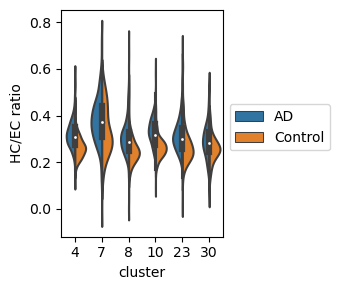

In [173]:
ad_features=np.array([])
clusterID_ad=np.array([])
clusterID_control=np.array([])
control_features=np.array([])
for c in hcClusters:
    if np.sum(res_pred_mode==c)<50:
        continue
    ad_features_c=hc_ec_content[np.logical_and(allCat=='AD',res_pred_mode==c)]
    control_features_c=hc_ec_content[np.logical_and(allCat=='CTRL',res_pred_mode==c)]
    clusterID_ad=np.concatenate((clusterID_ad,np.repeat(str(int(c)),ad_features_c.size)))
    clusterID_control=np.concatenate((clusterID_control,np.repeat(str(int(c)),control_features_c.size)))
    ad_features=np.concatenate((ad_features,ad_features_c))
    control_features=np.concatenate((control_features,control_features_c))
fig,ax=plt.subplots(figsize=(3.5,3),layout='constrained')
nmcoplot=pd.DataFrame({'pheno':np.concatenate((np.repeat('AD',ad_features.size),np.repeat('Control',control_features.size))),'HC/EC ratio':np.concatenate((ad_features,control_features)),'cluster':np.concatenate((clusterID_ad,clusterID_control))})
sns.violinplot(nmcoplot,y='HC/EC ratio',x='cluster',hue='pheno',split=True)
ax.legend(loc='lower left',bbox_to_anchor=(1, 0.35))
fig.tight_layout()
plt.savefig(os.path.join(plotsavepath,'AD_Control_hc_ec_content_heldoutSamples.pdf'))
# plt.ylim(-2,3)
plt.show()

In [160]:
#exclude overlapping patients
uniqueIdx=np.repeat(True,allPatientIDs_new.size)
ps=[]
for i in overlapID:
    uniqueIdx[allPatientIDs_new==i]=False
for c in hcClusters:
    if np.sum(res_pred_mode==c)<50:
        continue
    diff=np.mean(hc_ec_content[np.logical_and(np.logical_and(allCat=='AD',uniqueIdx),res_pred_mode==c)])-np.mean(hc_ec_content[np.logical_and(np.logical_and(allCat=='CTRL',uniqueIdx),res_pred_mode==c)])
    pval=scipy.stats.ttest_ind(hc_ec_content[np.logical_and(np.logical_and(allCat=='AD',uniqueIdx),res_pred_mode==c)],hc_ec_content[np.logical_and(np.logical_and(allCat=='CTRL',uniqueIdx),res_pred_mode==c)],alternative='greater')[1]
    print(c,pval,diff)
    ps.append(pval)

4 2.0238153039240786e-17 0.05619373141966977
7 0.06863261277926155 0.035029836376997636
8 4.946964961531824e-14 0.05605516056868948
10 2.4846145969893455e-36 0.07758778941788397
23 4.210263564989681e-12 0.053923377200582545
30 0.015664186225772057 0.03737809507146089


In [161]:
scipy.stats.false_discovery_control([ps])

array([[2.02381530e-17, 6.86326128e-02, 4.94696496e-14, 2.48461460e-36,
        4.21026356e-12, 1.56641862e-02]])

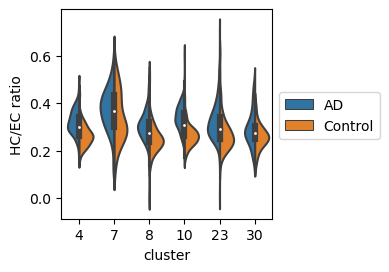

In [174]:
ad_features=np.array([])
clusterID_ad=np.array([])
clusterID_control=np.array([])
control_features=np.array([])
for c in hcClusters:
    if np.sum(res_pred_mode==c)<50:
        continue
    ad_features_c=hc_ec_content[np.logical_and(np.logical_and(allCat=='AD',uniqueIdx),res_pred_mode==c)]
    control_features_c=hc_ec_content[np.logical_and(np.logical_and(allCat=='CTRL',uniqueIdx),res_pred_mode==c)]
    clusterID_ad=np.concatenate((clusterID_ad,np.repeat(str(int(c)),ad_features_c.size)))
    clusterID_control=np.concatenate((clusterID_control,np.repeat(str(int(c)),control_features_c.size)))
    ad_features=np.concatenate((ad_features,ad_features_c))
    control_features=np.concatenate((control_features,control_features_c))

fig,ax=plt.subplots(figsize=(3,3),layout='constrained')
nmcoplot=pd.DataFrame({'pheno':np.concatenate((np.repeat('AD',ad_features.size),np.repeat('Control',control_features.size))),'HC/EC ratio':np.concatenate((ad_features,control_features)),'cluster':np.concatenate((clusterID_ad,clusterID_control))})
sns.violinplot(nmcoplot,y='HC/EC ratio',x='cluster',hue='pheno',split=True)
ax.legend(loc='lower left',bbox_to_anchor=(1, 0.35))
plt.savefig(os.path.join(plotsavepath,'AD_Control_hc_ec_content_heldoutPatients.pdf'))
fig.tight_layout()
# plt.ylim(-2,3)
plt.show()